# Pre-procesamiento de datos de EEG con MNE-Python (parte 3)
## Limpieza de datos 

En esta tercera parte se trabajará la técnica ICA (Independent Component Analysis) para remover elementos extraños de la señal asociados a movimientos oculares.

## 0. Cargar paquetes

El paso cero es la carga de los paquetes. Es decir, la carga de las distintas funciones que vamos a estar utilizando en el script.

In [1]:
import mne
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

## 1. Carga de datos

Posteriormente, cargamos los datos en formato .fif que ya se encuentran **referenciados**, **filtrados** y **limpios**. 

In [2]:
subject_id = "SAAV0009"
task = "TOL"

raw = mne.io.read_raw_fif(("../data/" + task + "/preprocessing/" + subject_id + "_" + task +"_REF_FILT_ANNOT.fif"), preload=True)
print(raw.info)

Opening raw data file ../data/TOL/preprocessing/SAAV0009_TOL_REF_FILT_ANNOT.fif...
    Range : 0 ... 736255 =      0.000 ...   718.999 secs
Ready.


C:\Users\Fede\AppData\Local\Temp\ipykernel_560\2353139601.py:4: RuntimeWarning: This filename (../data/TOL/preprocessing/SAAV0009_TOL_REF_FILT_ANNOT.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(("../data/" + task + "/preprocessing/" + subject_id + "_" + task +"_REF_FILT_ANNOT.fif"), preload=True)


Reading 0 ... 736255  =      0.000 ...   718.999 secs...
<Info | 12 non-empty values
 bads: 1 items (EXG8)
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 65 EEG, 2 misc, 3 EOG, 2 ECG, 1 Stimulus
 custom_ref_applied: True
 dig: 67 items (3 Cardinal, 64 EEG)
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 lowpass: 40.0 Hz
 meas_date: 2023-11-13 11:51:57 UTC
 meas_id: 4 items (dict)
 nchan: 73
 projs: []
 sfreq: 1024.0 Hz
>


# 2. ICA


## 2.1. Inspección previa 

Setting 6020 of 736256 (0.82%) samples to NaN, retaining 730236 (99.18%) samples.


Effective window size : 2.000 (s)


c:\Users\Fede\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


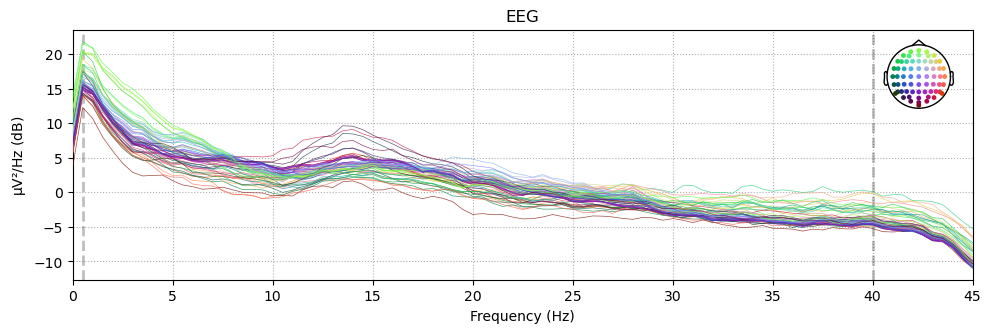

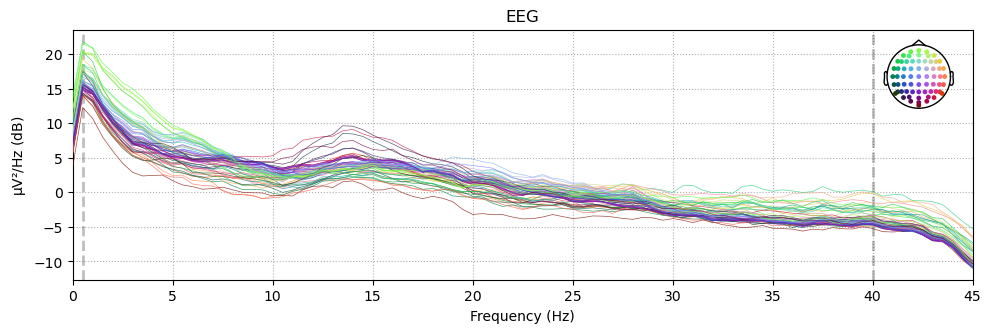

In [3]:
raw = raw.set_montage("biosemi64", on_missing="ignore")

raw.compute_psd(fmax=45).plot(picks="eeg")

## 2.2. Implementando modelo ICA

Ahora implementaremos un modelo estadístico para identificar estadísticamente a los movimientos oculares.


In [8]:
ica = ICA(n_components=30, max_iter="auto", random_state=97)
ica.fit(raw, reject_by_annotation=True)
ica

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Omitting 6020 of 736256 (0.82%) samples, retaining 730236 (99.18%) samples.
Selecting by number: 30 components


c:\Users\Fede\anaconda3\envs\mne\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA took 471.4s.


Method,fastica
Fit,1000 iterations on raw data (730236 samples)
ICA components,30
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=35, n_times=736256
    Range : 0 ... 736255 =      0.000 ...   718.999 secs
Ready.


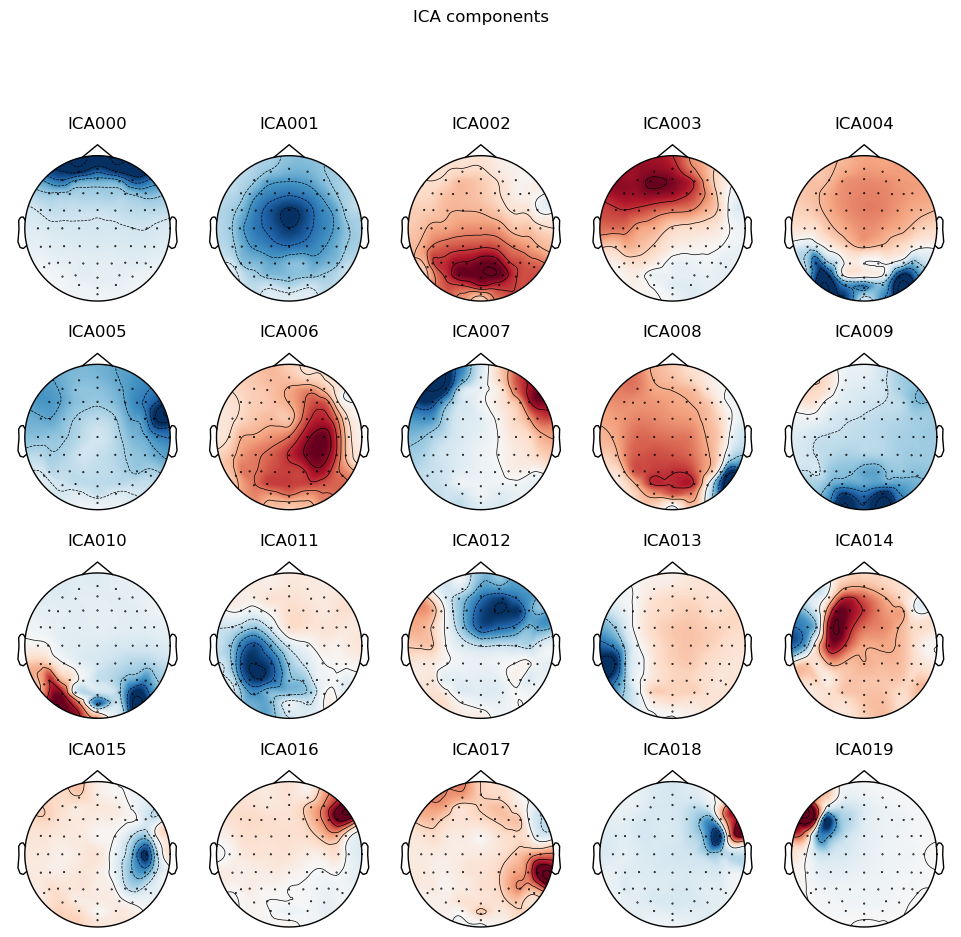

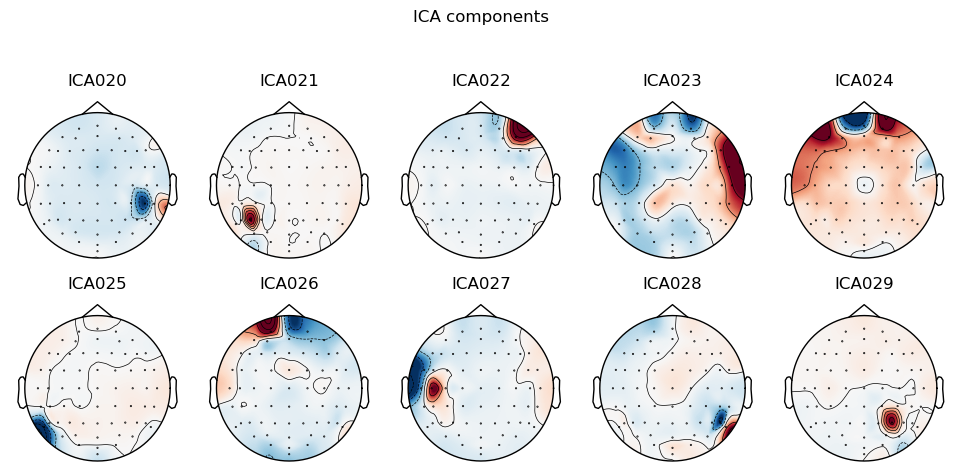

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x496 with 10 Axes>]

Channels marked as bad:
['EXG8']


In [9]:
#raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)


ica.plot_components()

In [10]:
explained_var_ratio = ica.get_explained_variance_ratio(
    raw, components=[0,7], ch_type="eeg"
)
# This time, print as percentage.
ratio_percent = round(100 * explained_var_ratio["eeg"])
print(
    f"Fraction of variance in EEG signal explained by selected component(s): "
    f"{ratio_percent}%"
)

Fraction of variance in EEG signal explained by selected component(s): 30%


Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


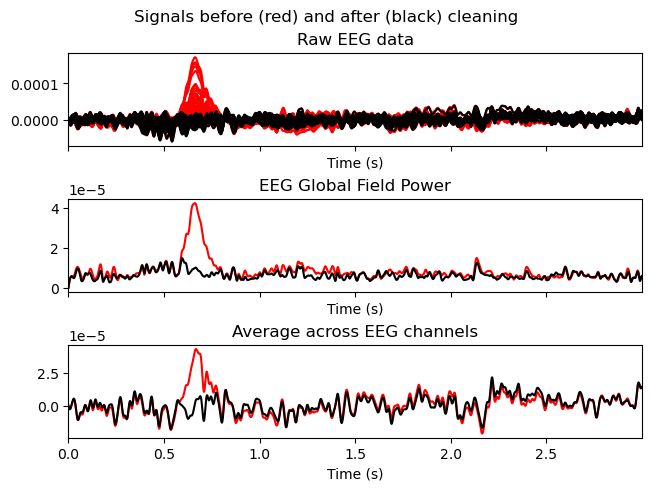

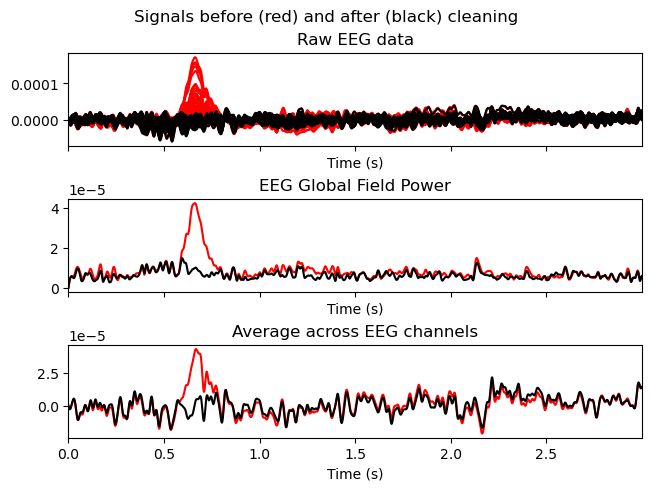

In [12]:
# blinks
ica.plot_overlay(raw, exclude=[0,7])

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
346 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
346 matching events found
No baseline correction applied
0 projection items activated


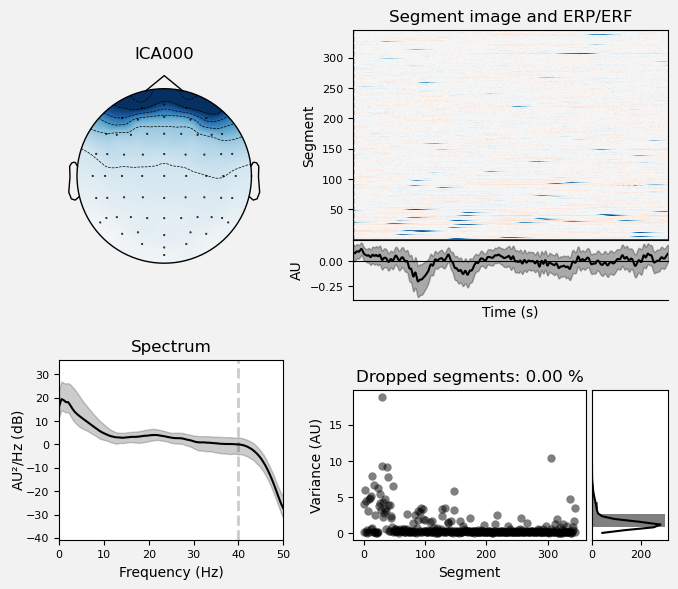

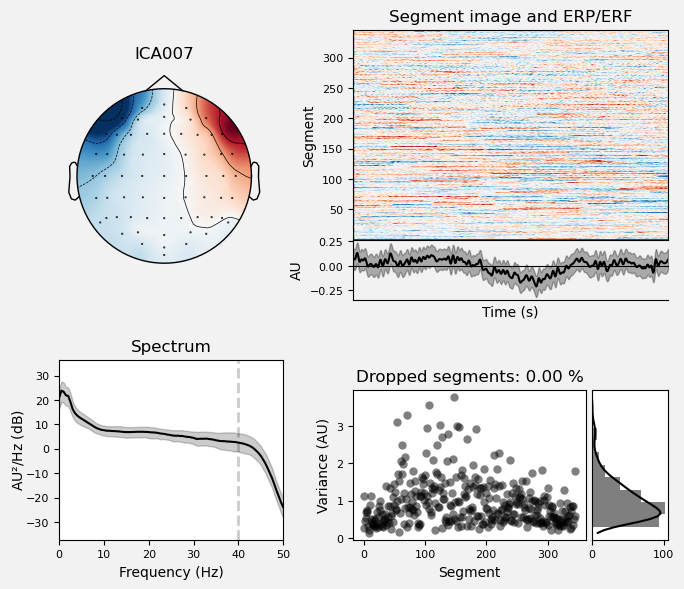

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [13]:
ica.plot_properties(raw, picks=[0,7])

In [14]:
ica.exclude = [0,7]


ica_raw = raw.copy()
ica.apply(ica_raw)



Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


<Raw | SAAV0009_TOL_REF_FILT_ANNOT.fif, 73 x 736256 (719.0 s), ~410.1 MB, data loaded>

## 2.1. Inspección posterior

Volvemos a graficar el espectro. Ahora para ver las diferencias con el anterior

Setting 6020 of 736256 (0.82%) samples to NaN, retaining 730236 (99.18%) samples.


Effective window size : 2.000 (s)


c:\Users\Fede\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


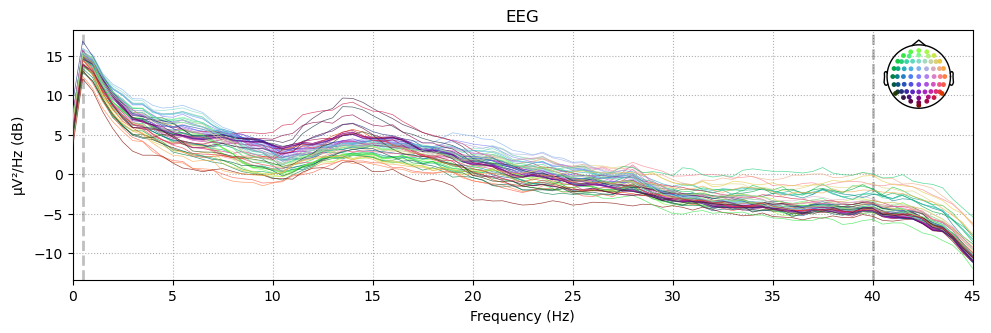

In [15]:
ica_raw.compute_psd(fmax=45, reject_by_annotation=True).plot(picks="data", exclude="bads")

# 4. Guardar datos limpios

In [16]:
ica_raw.save(("../data/" + task + "/preprocessing/" + subject_id + "_" + task +"_REF_FILT_ANNOT_ICA.fif"), overwrite=True)


Writing e:\Procesamiento EEG\scripts\..\data\TOL\preprocessing\SAAV0009_TOL_REF_FILT_ANNOT_ICA.fif


C:\Users\Fede\AppData\Local\Temp\ipykernel_560\1030269301.py:1: RuntimeWarning: This filename (e:\Procesamiento EEG\scripts\..\data\TOL\preprocessing\SAAV0009_TOL_REF_FILT_ANNOT_ICA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ica_raw.save(("../data/" + task + "/preprocessing/" + subject_id + "_" + task +"_REF_FILT_ANNOT_ICA.fif"), overwrite=True)


Closing e:\Procesamiento EEG\scripts\..\data\TOL\preprocessing\SAAV0009_TOL_REF_FILT_ANNOT_ICA.fif
[done]
